# Two dimensional Cartesian Slepians, generalized

The idea here is to use slepian_foxtrot to jumpstart an implementation of the Simons code. We should be able to then localize blobs, or splined boundaries of things in order to get the GL nodes and solve the concentration problem. 

`slepian_foxtrot` depends on `slepian_alpha`, so the routines from `slepian_alpha` that are needed have been collected in an input file. 

In [1]:
using FastGaussQuadrature, Plots, DelimitedFiles, Random, Slepians, KernelMatrices, KrylovKit, IterTools, FFTW
Random.seed!(123)

include("relevant_slepian_alpha.jl")

include("../src/RHMatrix.jl")

┌ Info: Precompiling Slepians [97caf2bd-9cc0-4738-8821-c8999f46f3c9]
└ @ Base loading.jl:1423
┌ Warning: Package Slepians does not have Statistics in its dependencies:
│ - If you have Slepians checked out for development and have
│   added Statistics as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Slepians
└ Loading Statistics into Slepians from project dependency, future warnings for Slepians are suppressed.


Main.RHMatrix

## Random blob example

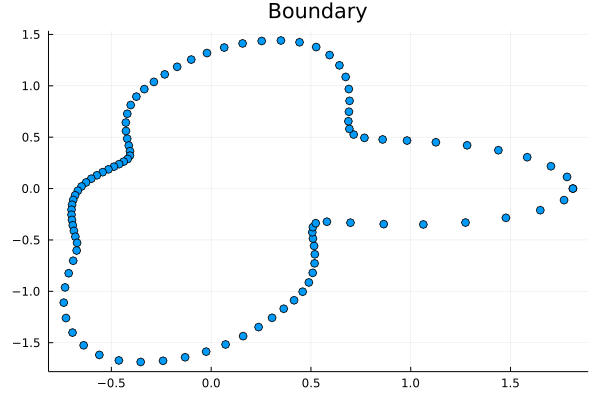

In [2]:
x, y = blob(1,1)

p = scatter(x[1], y[1],  marker = :o, title = "Boundary", legend = false)

## Get the quadrature nodes

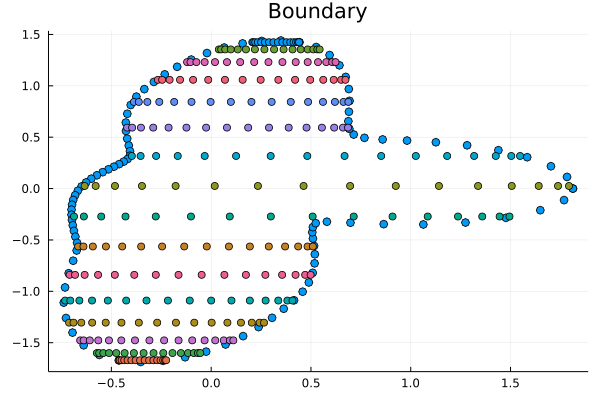

In [3]:
QX, QY, w, Nrun = get_quadrature_nodes_2D(x[1], y[1], 16, 16)

# Initialize the quadrature points
scatter!(p, QX, QY, legend = false)

## Integrate

Now we just use the code that does the numerical integration, and Bob's your uncle.

In [4]:
# Run the custom slepians - small modifications made to the main code:
# https://github.com/lootie/Slepians.jl/blob/master/src/dDimSleps.jl

function customsleps_ext(M::Int64, Kp, szs; prec = 1.0e-8, exact = false, lvl = 6, maxrank = 0, 
    no = nothing, sqwt = nothing, int = nothing, ev = nothing)
    # Create the kernel matrix, exactly or via HODLR approximation:
    _K    = KernelMatrix(no, no, Kp, dfn)
    K     = exact ? full(_K) : RHMatrix.rhodlr(_K, lvl, prec, maxrank)

    # Solve the eigenvalue problem (86) to obtain the slepians at the quad nodes:
     s     = eigsolve(z -> sqwt .* (K * (sqwt .* z)), length(sqwt), M, :LM, 
                        issymmetric = true)
    outputsize = (int == nothing) ? szs : int
    # Prepare even grid points, compute Slepians at those points:
    evpts = (ev != nothing) ? ev : vec(collect(product([range(-1.0, 1.0, length = s) for s in outputsize]...)))

    _K2   = KernelMatrix(evpts, no, Kp, dfn)
    K2    = exact ? full(_K2) : RHMatrix.rhodlr(_K2, lvl, prec, maxrank)
    sleps = [(K2 * (sqwt .* x[2])) ./ x[1] for x in zip(s[1], s[2])]
    sl = [reshape(sp, (16, 16)...) for sp in sleps];
    return s[1], [reshape(sp, outputsize...) for sp in sleps]
end

customsleps_ext (generic function with 1 method)

In [5]:
# Set the parameters for the custom Slepians

M  = 3
Kp = [4.0]
szs = int = (16, 16)
prec = 1e-8
exact = false
lvl = 6
maxrank = 256


256

In [6]:
no    = map(i->(QX[i], QY[i]), 1:prod(size(QX)))
sqwt = sqrt.(w[:]);

Get the nodes and weights into the sizes and shapes that the solving routine wants.

In [7]:
ev = vec(collect(product([range(minimum(QX), maximum(QX), length = szs[1]), range(minimum(QY), maximum(QY), length = szs[2]) ]...)))
s, sl = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = no,
        sqwt = sqwt, int = nothing, ev = ev);

Plot the results

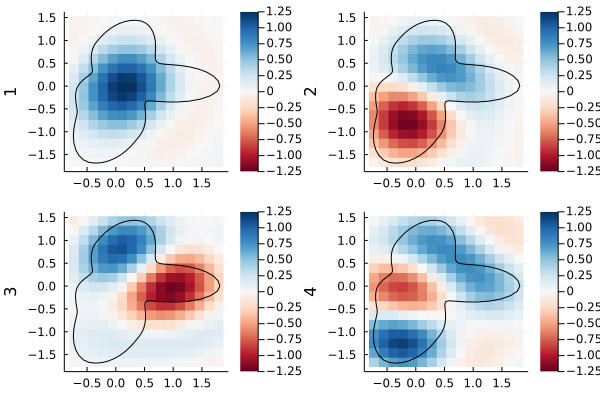

In [8]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ran = 1:4
for i = ran
    p1[i] = heatmap(range(minimum(QX), maximum(QX), length = szs[1]), 
         range(minimum(QY), maximum(QY), length = szs[2]), Float64.(sl[i])',
        c = :RdBu, clims = (-1.25, 1.25), ylabel = i) # this transpose is important
    plot!(p1[i], x[1], y[1], legend = false, c = :black)

    SL = abs2.(fftshift(fft(sl[i])))
    p2[i] = heatmap(log10.(SL), ylabel = i)
end

plot(p1[ran]...)

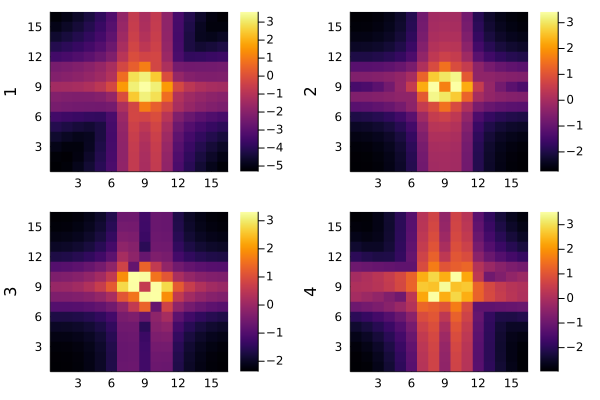

In [9]:
plot(p2[ran]...)

## Second example - rattle shape

How does the code set up quadrature nodes for disjoint circles?

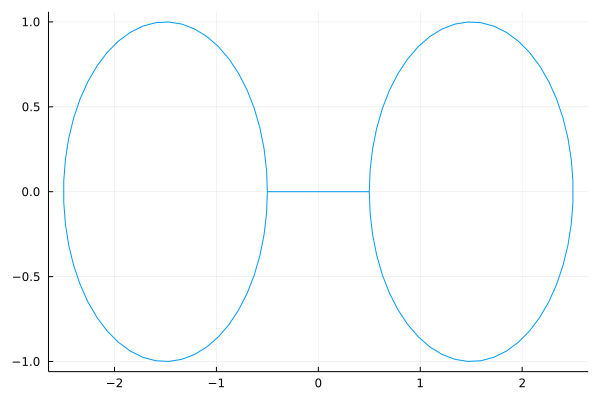

In [10]:
N = 50
t = LinRange(-pi, pi, N)
x1, y1 = (cos.(t) .+ 1.5, sin.(t))
x2, y2 = (cos.(t .+ pi) .- 1.5, sin.(t .+ pi))

xp,yp = (vcat(x1,x2), vcat(y1, y2))

plot(xp,yp, legend = false)

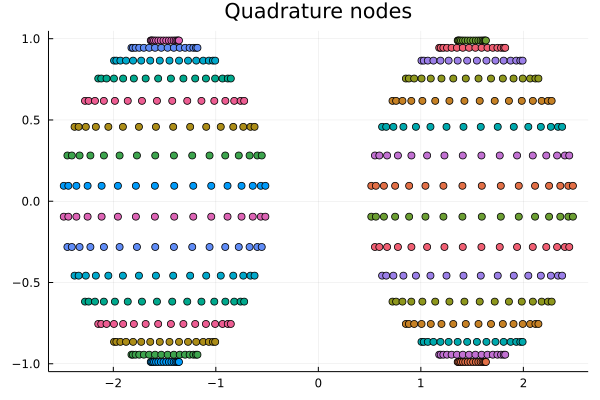

In [11]:
QXp, QYp, wp, Nrunp = get_quadrature_nodes_2D(xp, yp, 16, 16)
psp = scatter(QXp, QYp, legend = false, title = "Quadrature nodes")

In [12]:
nop    = map(i->(QXp[i], QYp[i]), 1:prod(size(QXp)))
sqwtp = sqrt.(wp[:]);
size(sqwtp)

(512,)

In [13]:
evp = vec(collect(product([range(minimum(QXp), maximum(QXp), length = szs[1]), range(minimum(QYp), maximum(QYp), length = szs[2]) ]...)))

sp, slp = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = nop,
        sqwt = sqwtp, int = nothing, ev = evp);

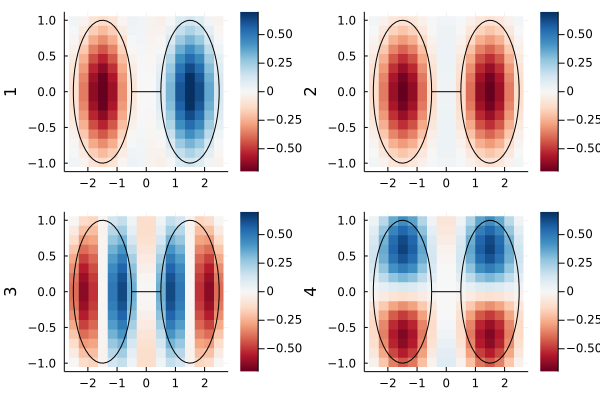

In [14]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ran = 1:4
for i = ran
    p1[i] = heatmap(range(minimum(QXp), maximum(QXp), length = szs[1]), 
         range(minimum(QYp), maximum(QYp), length = szs[2]), Float64.(slp[i])',
        c = :RdBu, ylabel = i, clims = (-0.7, 0.7)) # this transpose is important
    plot!(p1[i], xp, yp, legend = false, c = :black)

    SL = abs2.(fftshift(fft(slp[i])))
    p2[i] = heatmap(log10.(SL), ylabel = i)
end

plot(p1[ran]...)

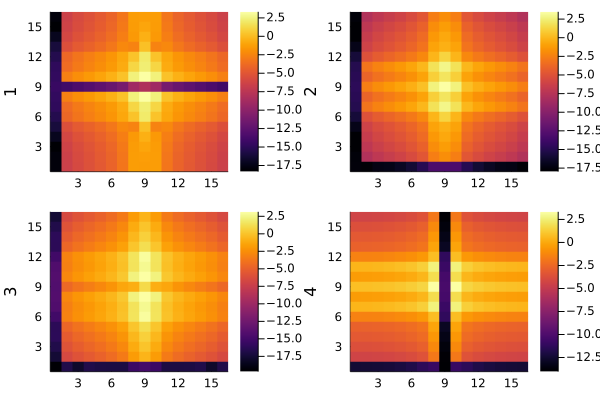

In [15]:
plot(p2[ran]...)